# Phonological Processing
Dastan Abdulla  
Ling 1340: Data Science for Linguists  
04/08/2024  

## About this Notebook
The goal of this notebook is to process and fix any issues with the transcription content and then use `Panphon` to analyze and extract the features of the IPA segments for each transcription entry.

## Table of Content
- [Checking for Parsing Abnormalities](#checking-for-parsing-abnormalities)
- [Phoneme Word Segment Level Analysis](#phoneme-word-segment-level-analysis)
- [Cleaning Up the Column Structure](#cleaning-up-the-column-structure)
- [Processing the Transcription Column Using Panphon](#processing-the-transcription-column-using-panphon)
- [Saving the Modified Data Frames](#saving-the-modified-data-frames)

In [379]:
# Imports
import pandas as pd
import numpy as np
# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [380]:
# Reloading the data frame
saa_df = pd.read_pickle("../data/saa_df.pkl")

## Checking for Parsing Abnormalities

In [381]:
saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,transcription,language_name
34,35,bengali,zambia,25.0,female,2.0,usa,21.0,naturalistic,bengali2.wav,bengali2.txt,ben,\[pʰl̥iːz kʰɑːl stɛlʌ æsk hɚ ɾə bɹɪŋ ðiz θɪŋz ...,Bengali
446,446,english,usa,19.0,male,0.0,usa,17.0,naturalistic,english118.wav,english118.txt,eng,\[pʰliːz kʰɑlˠ stɛlə æsk hə ɾə bɹɪ̃ŋ ðiːz θɪ̃ŋ...,English
1131,1130,amharic,ethiopia,26.0,female,15.0,usa,10.0,academic,amharic12.wav,amharic12.txt,amh,\[pʰlis kol ɪstɛlʌ æsk hɝ tu bɹɪ̃ŋ dɪs t̪ɪ̃ŋs ...,Amharic
605,603,mende,sierra leone,21.0,female,2.0,"sierra leone, usa",21.0,naturalistic,mende2.wav,mende2.txt,men,\[pliz̥ kɒ sæli æks hɜ tu bɹɪ̃ŋ θɪ̃ŋs wɪ hɜ fɹ...,Mende (Sierra Leone)
1968,1969,english,canada,39.0,female,0.0,"canada, usa, uk, cayman islands",36.0,naturalistic,english543.wav,None,eng,None,English


In [382]:
# let's only look at entries that have been transcribed already
transcribed_saa_df = saa_df[saa_df['transcription'].notnull()].copy()
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,transcription,language_name
1393,1394,arabic,usa,19.0,female,9.0,usa,12.0,academic,arabic38.wav,arabic38.txt,acw,\[pʰliːz̥ kɑːlˠ stɛlə æ̞sk həɹ tʰə bɹɪ̃ŋ d̪iz̥...,Hijazi Arabic
366,367,tamil,sri lanka,39.0,male,7.0,usa,13.0,academic,tamil1.wav,tamil1.txt,tam,\[pʰliz̥ kʰɒɭ stɛlə ask ɛɹ tŭ bɽɪ̃ŋ d̪iz̥ θɪ̃...,Tamil
2941,2947,catalan,spain,55.0,female,35.0,ireland,0.1,academic,catalan6.wav,catalan6.txt,cat,\[pliːz̥ kɔl ĕstɛlʌ xæs xeɹ tʰu bɾɪ̃ŋ d̪iːs θ...,Catalan
341,342,spanish,spain,34.0,male,14.0,ireland,0.1,academic,spanish27.wav,spanish27.txt,spa,\[pliz̥ kol stɛlə æsx heɹ tu bɹɪ̃ŋ̟ ðɪs θɪ̃ŋ̟z...,Spanish
16,17,arabic,qatar,24.0,male,9.0,usa,1.0,academic,arabic3.wav,arabic3.txt,afb,\[plis kol stɛːl stɛla ɑsk her tu bɹɪ̃ŋ ðis θɪ...,Gulf Arabic


In [383]:
# let's check if there any abnormalities for the transcriptions
transcribed_saa_df['transcription_lengths'] = transcribed_saa_df['transcription'].str.len()
transcribed_saa_df['transcription_lengths'].describe()

count    1269.000000
mean      345.217494
std        32.098920
min       302.000000
25%       330.000000
50%       339.000000
75%       350.000000
max       563.000000
Name: transcription_lengths, dtype: float64

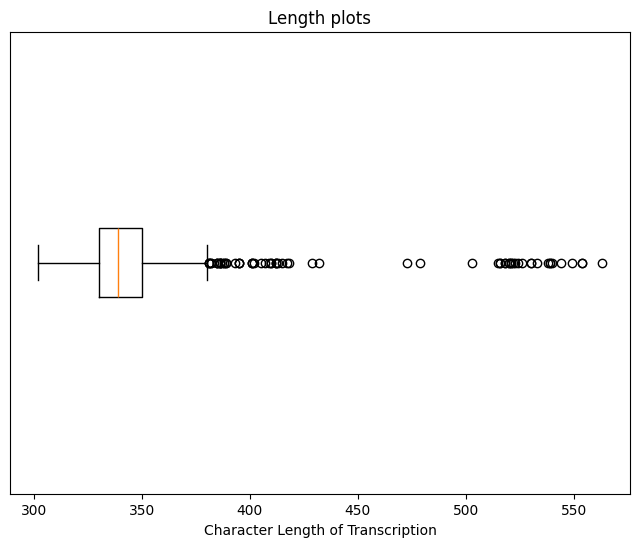

In [384]:
plt.figure(figsize=(8, 6)) 
plt.boxplot(transcribed_saa_df['transcription_lengths'], vert=False) 
plt.title('Length plots')
plt.xlabel('Character Length of Transcription')
plt.yticks([]) 
plt.show()

* Let's examine some of those outliers

In [385]:
transcribed_saa_df[transcribed_saa_df['transcription_lengths'] > 375].describe()

,speakerid,age,onset_age,length_of_residence,transcription_lengths
count,75.000000,75.000000,75.000000,75.000000,75.000000
mean,834.146667,36.373333,15.253333,11.458000,443.866667
std,442.263578,12.711745,11.538529,13.995214,65.981433
min,7.000000,19.000000,0.000000,0.000000,377.000000
25%,456.500000,25.500000,7.000000,1.250000,386.000000
50%,991.000000,35.000000,12.000000,5.000000,410.000000
75%,1098.500000,45.000000,18.500000,17.500000,520.000000
max,1632.000000,72.000000,48.000000,52.000000,563.000000


In [386]:
transcribed_saa_df[transcribed_saa_df['transcription_lengths'] > 375].sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,transcription,language_name,transcription_lengths
1457,1458,arabic,saudi arabia,39.0,male,16.0,usa,0.75,academic,arabic47.wav,arabic47.txt,acw,\[p̬əlizː əː kol əstɛl ask hir tu̞ bɪ̆rɪ̃ŋk d̪...,Hijazi Arabic,418
971,970,arabic,egypt,40.0,male,7.0,uk,3.00,academic,arabic24.wav,arabic24.txt,arz,\[bis kɔl əː siə əː sitla ask hɛr tu bɹɪ̃ŋ əː ...,Egyptian Arabic,386
1623,1623,farsi,iran,54.0,female,38.0,usa,16.00,naturalistic,farsi16.wav,farsi16.txt,pes,\[plis kʰɑl ɛ̆stɛla ask hɛr tʰŭ bə̆rɪ̃ŋ d̪iːs...,Iranian Persian,379
964,963,pashto,afghanistan,36.0,female,7.0,usa,17.00,naturalistic,pashto3.wav,pashto3.txt,pbt,\[\_ pli_z\_ k\_\_l\_ st\_\_l hæ_sk h\_\_\_ t_...,Southern Pashto,563
757,757,nepali,nepal,37.0,female,14.0,usa,4.00,academic,nepali2.wav,nepali2.txt,npi,\[pl̥is kaːl s̩ stel̥ n̩ ha aːs hɚ tʰu bɪɡɪnɪ̃...,Nepali (individual language),409


- It looks like some of them did not get parsed correctly, let's examine the contents of the ones that did not get parsed appropriately

In [387]:

outliers_df = transcribed_saa_df[
    (transcribed_saa_df['transcription_lengths'] > 375) &
    (transcribed_saa_df['transcription'].str.contains('-'))
]
outliers_df['transcription_lengths'].describe()


count     30.000000
mean     517.333333
std       38.396599
min      380.000000
25%      516.500000
50%      522.500000
75%      538.750000
max      563.000000
Name: transcription_lengths, dtype: float64

In [388]:
for index, row in outliers_df.sample(2).iterrows():
    file_path = '../data/transcriptions_text/' + row['phonetic_transcription']
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            contents = file.read()
            print(f"Contents of {file_path}:")
            print(contents)
    except FileNotFoundError:
        print(f"File {file_path} not found.")

Contents of ../data/transcriptions_text/krio4.txt:
---
author: accent
title: \[pli\_\_s k_l st_l\_ æsk h\_ t\_ b\_\_\_\_ \_\_s \_\_\_\_ks
  w\_\_ h\_\_ f\_\_\_m \_\_ st\_ s_ks spu_ns \_f f\_\_\_ \_no p_i\_\_s
  fa_f \_\_k s\_ slæ\_\_bs \_f bl\_\_ t\_
---

\[pliːs kɑl stɛlə æsk hɜ tʊ bɹɪ̃ŋ d̪ŏs θɪ̃ŋks wɪð hɜ fɹʌ̃m ðɜ stɔ sɪks spũns
əf frɛʃ s̠no pʰi̞ːs faɪf t̪ɪk s̩ slæ̝ːps ɔf blʊ tʃi̞ːs æ̝̃n mebiː ə sːnæ̞k fɔ hɜ
bɹʌdə bap̚ wʉ ɑlso nid ə smɑl pʰlæstɪk sneɪk æ̃n ə biːɡ̥ tʃɔɪ frɔɡ̥̚ fɔ də
kɪːs ʃi kɛ̃n skup dos t̪ɪ̃ŋs ɪ̃ntu d̪ɪs ɹɛd̥̚ bæ̝ːks ɛ̃n wi wɪl ɡo nidə w̩ wi wɪl
ɡo mit hɜ wɛ̃nsdeɪ æt̚ d̪ə tɹeɪ̃n steɪʃə̃n\]

Contents of ../data/transcriptions_text/russian26.txt:
---
author: accent
title: \[pli_s k_l\_ st_l\_ ask x\_\_ tu b\_\_\_n d\_\_s \_\_\_\_s w\_\_
  h\_\_\_ \_ f\_\_\_m \_\_ st\_\_ s_ks spu_ns \_f fr\_\_ \_no pi_s fa_f
  \_\_k \_slabs \_v blu t_i\_
---

\[pliːs kɔlˠ stɛlʌ ask xɜ˞ tu bɹɪ̃n ðosː θɪ̃ŋs wɪθ hɜ˞ː ʌ fɹʌ̃m ðə stɔɹ
sɪks spũns ʌf frɛʃ sno piːs faɪf θɪk ʔslabs ʌv̥ blu tʃ

* It seems like there are there 2 sets of brackets in those files and we're reading in only the first ones, let's see if we can make our matching more specific
* For this task, Python's string function's alone won't be enough, we need to use regular expressions.

In [389]:
import re

# Helper function to extract from the correct set of brackets
def extract_bracketed_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    # This looks scary but all it does is get the set of brackets that do not have a dash between the opening and closing
    pattern = r'\[((?:[^\-\[\]]|\[[^\-\[\]]*\])*)\]'
    # Find all matches of the pattern
    match = re.search(pattern, content)
    if match:
        # Groups are 1-indexed, so 1 refers to the first group
        return match.group(1)  
    else:
        return None

In [390]:
# let's test it out
test = extract_bracketed_content('../data/transcriptions_text/spanish66.txt')
test

'pʰliːz kɑl stɛla æsk hə˞ ɾə bɹɪ̃ŋ d̪iz̥ s̪ɪ̃ŋz̥ wɪθ hɜ˞ fɹʌ̃m ðə stɔːɹ sɪks\nspũːns əf fɹɛʃ snoʊ pʰiːz faɪv θɪk slæbz əv blu tʃiːz ɛ̃nd meɪbi ə snæk̚\nfɔɹ hɜ˞ bɹʌðə˞ bɑːbə̆ wi ɑlˠso niɾ ə smɑl plæsɪk̚ sneɪk ɛ̃nd ə̆ bɪɡ̥̚ tʰɔɪ\nfɹɑːɡ fə˞ ðə kʰɪːdz ʃi kə̃n skup̚ ðiːz̥ s̪ɪ̃ŋz ɪ̃ntu θɹi ɹɛd bæːɡz ɛ̃n wi wɪlˠ\nɡoʊ miɾ ɚ wɛ̃nzeɪ æt̚ ðə tʰɹeɪ̃n steɪʃə̃n\\'

In [391]:
# Let's try it for all of them
for index, row in outliers_df.iterrows():
    file_path = '../data/transcriptions_text/' + row['phonetic_transcription']
    try:
        transcript = extract_bracketed_content(file_path)
        outliers_df.at[index, 'transcription'] = transcript
        outliers_df.at[index, 'transcription_lengths'] = len(transcript)
    except FileNotFoundError:
        print(f"File {file_path} not found.")

In [392]:
outliers_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,transcription,language_name,transcription_lengths
487,487,english,usa,34.0,female,0.0,usa,34.0,naturalistic,english126.wav,english126.txt,eng,pʰliːz kʰɑlˠ stɛlə æsk ɚ ɾə bɹɪ̃ŋ n̪iːz θɪ̃ŋz ...,English,342
1184,1184,ibibio,nigeria,52.0,male,3.0,"nigeria, uk, usa",52.0,naturalistic,ibibio1.wav,ibibio1.txt,ibb,pʰliz̥ kɔl stɛ̝lă æs ha t̪u bɹɪ̃ŋ dɪs t̪ɪ̃ŋz̥...,Ibibio,336
1354,1355,pashto,afghanistan,52.0,female,22.0,usa,28.0,naturalistic,pashto5.wav,pashto5.txt,pbt,pʰliːz̥ kaːl stɛlə ask hɜr tu brɪ̃ŋk d̪iːz̥ t̪...,Southern Pashto,377
492,492,english,united kingdom of great britain and northern i...,25.0,male,0.0,"uk, australia",25.0,naturalistic,english129.wav,english129.txt,eng,pʰliːz kʰɒlˠ stɛ̝la̙ æsk ə ɾə bɹɪ̃ŋ n̪ə̆ɪz̥ θɪ...,English,341
496,496,english,south africa,32.0,male,0.0,south africa,32.0,naturalistic,english130.wav,english130.txt,eng,pʰliːz kʰɒl stɛ̝lə as hə tə bɹɪ̃ŋ ðɪːz θɪ̃ŋz w...,English,334


In [393]:
outliers_df['transcription_lengths'].describe()

count     30.000000
mean     351.333333
std       15.100430
min      328.000000
25%      340.250000
50%      347.500000
75%      359.750000
max      389.000000
Name: transcription_lengths, dtype: float64

- That looks a lot better, now let's try to merge the modified outlier transcripts into the original `transcribed_saa_df` and see how that changes the lengths.
- The ~15 standard deviation could be due to the feature conditions on the phonemes.

In [394]:
# Iterate over each row in outliers_df
for index, row in outliers_df.iterrows():
    # Update transcribed_saa_df for the matching speakerid
    transcribed_saa_df.loc[transcribed_saa_df['speakerid'] == row['speakerid'], 'transcription'] = row['transcription']
    transcribed_saa_df.loc[transcribed_saa_df['speakerid'] == row['speakerid'], 'transcription_lengths'] = row['transcription_lengths']

In [395]:
transcribed_saa_df['transcription_lengths'].describe()

count    1269.000000
mean      341.293144
std        16.924236
min       302.000000
25%       330.000000
50%       339.000000
75%       349.000000
max       432.000000
Name: transcription_lengths, dtype: float64

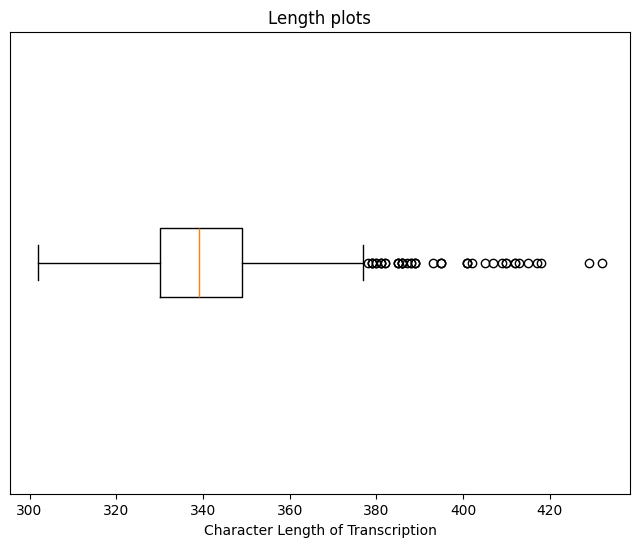

In [396]:
plt.figure(figsize=(8, 6)) 
plt.boxplot(transcribed_saa_df['transcription_lengths'], vert=False) 
plt.title('Length plots')
plt.xlabel('Character Length of Transcription')
plt.yticks([]) 
plt.show()

- That looks much better, however, there are still some outliers, let's see if we can do even better

In [397]:
transcribed_saa_df[transcribed_saa_df['transcription_lengths'] > 375].describe()

,speakerid,age,onset_age,length_of_residence,transcription_lengths
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,761.604167,36.979167,18.291667,7.371875,394.041667
std,512.896354,13.563859,11.621620,11.076359,14.692534
min,7.000000,19.000000,0.000000,0.000000,377.000000
25%,309.250000,26.000000,10.750000,0.937500,381.750000
50%,709.500000,36.000000,14.000000,2.500000,388.500000
75%,1241.500000,44.500000,25.250000,7.250000,405.500000
max,1632.000000,72.000000,45.000000,49.000000,432.000000


In [398]:
for index, row in transcribed_saa_df[transcribed_saa_df['transcription_lengths'] > 375].sample(5).iterrows():
    print(row['transcription'])
    print()

\[njaʊ pliz̥ kɔl eʌ pliz̥ kɔl stɪlə as hɜ tʰu brɪ̃ŋ d̪i d̪ɛ̃ŋ ə brɪ̃ŋ t̪ʰɪ̃ŋ wit̪
ha˞ frʌm d̪i əstɔr siks spũn ɔf fiʃ fəno ɔ fiʃ p̬ɪs faɪf t̪ʰɪ̃ŋks sl̩ ʌ slæ̝b̥
ɔf bɔf ʃis æ̝̃n maɪbi ə snæk fɔ˞ ha˞ brʌðər bɔb̥ wi ɔlso nid̥ æ̝ smɔl plæstɪk
snæk æ̃n ə bɪ̝k bɪ̝k tɔɪ fɹɔk̆̚ fɔɹ d̪i kit ʃi kæ̝̃n skʊp d̪ɛr t̪ʰɪ̃ŋ ɪ̃ntu ha˞ rɛd˺
bæɡ̥s æ̃n wi wɪl ɡo mit ha˞ wɛ̃n wɛ̃nəzd̥e æt d̪i tɹẽn isteʃən\

\[ɛ̆ pl̥iz kɔl stɛ̝lə ask hər tʰu brɪ̃ŋ ðis θɪ̃ŋɡz wiθ həɹ frɔm d̪ə stɔ̜̆ʔ tʰŭ
ðə stɔ̜r frɔm ðə stɔ̜r sɪks spũnz ɔ̜̆f frɛʃ snŏ pis faɪf θik sl̥ab̥s ɔ̜̆f βlu
tʃiz æ̝̃nd˺ mebiʔ sneɪk ɔ̆f həɹ bɹʌðr̩ bŏb̥ wi ɔlso nid ɛ̆ smɔl plastɪk snæ̆kʰ
ãn ĕ biks ĕ biɡ tɔɪ frɔɡ ðə nǀə frɔɡ frɔ fɔɹ ðə kɪ̝dz̥ ʃi kæ̃n˺ skupʰ d̪iz
θɪ̃ŋz ɪ̃n θri ɪ̃ntu θri rɛd˺ bæɡz ɛnd wi wɪ̝l ɡŏ mit hər wɛ̃nzdĕ æt˺ d̪ə treɪ̃n
steʃn̩\

\[pʰlis kʰɔl s̩ sɛtɛla ask hɜr tu brɪ̃ŋ d̪is t̪ɪ̃ŋəz wɪz hɜr fɹʌ̃ fɹʌ̃m d̪ɜ stɔr
sɪksə spʊ̃nz̥ ɔf fɹeʒ fɹɛʃ snõ pʰis faɪf t̪ɪk sːlæps ɔv̥ blu ʧʰiz æ̝̃nd meɪ̃bi
dɜ ɛs ʔʌ ɛsneɪk of hɜɹ braz̪ɜɹ bop wi ɔ

- It looks like that the '\\' is attached to the end, and some entries have newline characters in between, let's remove those.
- Also some strings use the `\xa0` which is a more purpose specific version of just the white space character so we can replace those as well.

In [399]:
def update_transcript(t):
    # Remove backslashes
    t = t.replace("\\", "")
    # Remove newline characters
    t = t.replace("\n", "")
    # Replace the escaped whitespace character
    t = t.replace("\xa0", " ")
    return t

transcribed_saa_df['transcription'] = transcribed_saa_df['transcription'].apply(update_transcript)
transcribed_saa_df['transcription_lengths'] = transcribed_saa_df['transcription'].str.len()

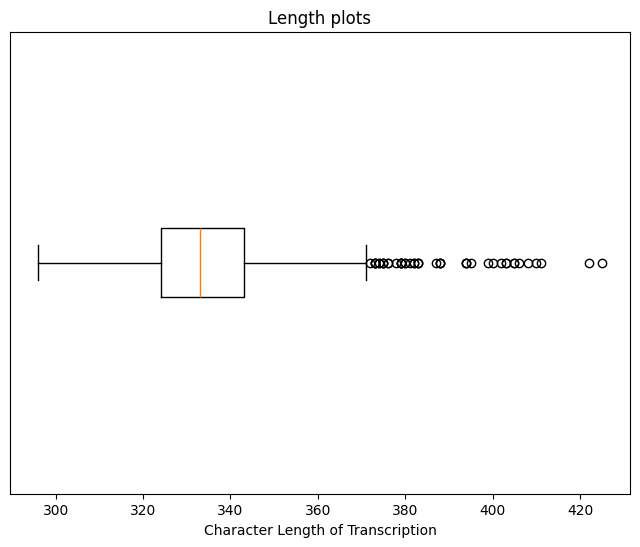

In [400]:
plt.figure(figsize=(8, 6)) 
plt.boxplot(transcribed_saa_df['transcription_lengths'], vert=False) 
plt.title('Length plots')
plt.xlabel('Character Length of Transcription')
plt.yticks([]) 
plt.show()

In [401]:
transcribed_saa_df['transcription_lengths'].describe()

count    1269.000000
mean      335.277384
std        16.852355
min       296.000000
25%       324.000000
50%       333.000000
75%       343.000000
max       425.000000
Name: transcription_lengths, dtype: float64

In [402]:
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,transcription,language_name,transcription_lengths
1277,1278,polish,poland,19.0,male,8.0,NaN,0.0,academic,polish16.wav,polish16.txt,pol,[pʰlɛiz̥ kʰɒl stʰɛlʌ ɛsk hɜ tə bɹɪ̃ŋ ðiz̥ θɪ̃ŋ...,Polish,320
245,246,kurdish,iraq,24.0,male,15.0,usa,1.5,academic,kurdish1.wav,kurdish1.txt,ckb,[plis kɑl stɛlʌ æsk hʲɚ tu bɹĩŋ ðɪs θĩŋz̥ wɪ...,Central Kurdish,331
861,860,french,france,20.0,male,12.0,uk,0.1,academic,french25.wav,french25.txt,fra,[pʰliːz̥ kʰɑːl stɛlə æsk əɹ tu bɹɪ̃ŋ d̪iz t̪ɪ̃...,French,328
1033,1032,hadiyya,ethiopia,30.0,male,11.0,usa,4.0,academic,hadiyya2.wav,hadiyya2.txt,hdy,[pliz kɑl stɛlə̆ æ̞sk hʌɹ tu bɹɪ̃ŋ zɪz̥ tɪ̃ŋɡə...,Hadiyya,349
566,564,english,jamaica,49.0,male,0.0,"jamaica, uk",49.0,naturalistic,english172.wav,english172.txt,eng,[pliːz kɑl stɛlə ask hɚ tə bɹɪ̃ŋ ðɪz θɪ̃ŋz wɪθ...,English,333


Some entries start with brackets, let's see if we can handle that.

In [403]:
def remove_extra_brackets(t):
    if t.startswith('[') or t.startswith('\['):
        t = t[1:]
    # Check and remove from the end incase
    if t.endswith(']') or t.endswith('\]'):
        t = t[:-1]
    return t

transcribed_saa_df['transcription'] = transcribed_saa_df['transcription'].apply(remove_extra_brackets)
transcribed_saa_df['transcription_lengths'] = transcribed_saa_df['transcription'].str.len()
transcribed_saa_df['transcription_lengths'].describe()

count    1269.000000
mean      334.301024
std        16.868507
min       295.000000
25%       323.000000
50%       332.000000
75%       342.000000
max       424.000000
Name: transcription_lengths, dtype: float64

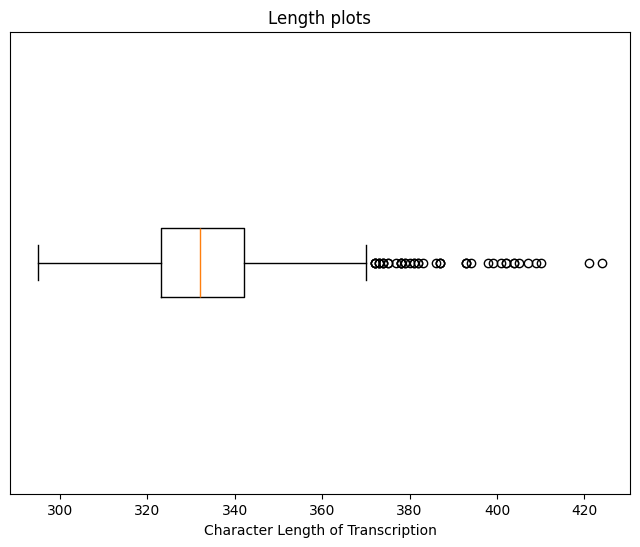

In [404]:
plt.figure(figsize=(8, 6)) 
plt.boxplot(transcribed_saa_df['transcription_lengths'], vert=False) 
plt.title('Length plots')
plt.xlabel('Character Length of Transcription')
plt.yticks([]) 
plt.show()

* The mean went down by 1 so that must be pretty significant.

## Phoneme Word Segment Level Analysis

- That looks a lot better, now let's look at the word alignment, represented by white space and see if there are any outliers, we can simply use split on `' '` to make a list and count the length of the list

In [405]:
def segment_count(transcript):
    segs = transcript.split(sep=" ")
    return len(segs)

segments = transcribed_saa_df['transcription'].apply(segment_count)
segments.describe()

count    1269.000000
mean       66.193853
std         3.001881
min        56.000000
25%        65.000000
50%        65.000000
75%        67.000000
max        89.000000
Name: transcription, dtype: float64

- Let's compare that to the word segments expected for the sentence utterance

In [406]:
sample = open('../data/sample_read.txt', 'r').read()

In [407]:
print("Expected word/segment count: ", len(sample.split(" ")))

Expected word/segment count:  69


- That's more or less inline with what we would expect, the low standard deviation of 3 is a good sign.
- let's drop the `transcription_lengths` column since we no longer need it.

In [408]:
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,transcription,language_name,transcription_lengths
875,874,cantonese,china,29.0,female,3.0,"usa, australia",4.0,academic,cantonese16.wav,cantonese16.txt,yue,plis kʰoː stɛla æsk hə tə bɹɪ̃ŋ d̪ɪs t̪ɪ̃ŋs wɪ...,Yue Chinese,317
562,560,czech,czech republic,60.0,male,45.0,NaN,0.0,naturalistic,czech2.wav,czech2.txt,ces,pə̆lis kal stɛlə azɣ xɛɹ tu briŋk d̪is ft̪iŋk ...,Czech,322
629,628,french,france,19.0,male,12.0,NaN,0.0,academic,french13.wav,french13.txt,fra,plis kɔl stɛlə ask ə˞ tu bɹɪ̃ŋ d̪ɪs sɪŋz wɪz ɜ...,French,314
626,625,arabic,morocco,43.0,male,18.0,usa,8.0,academic,arabic19.wav,arabic19.txt,ary,pliz kɔl stelʌ æ̝s hə æ̝sk hɛr tŭ brɪ̃ŋɪn d̪ɛ...,Moroccan Arabic,367
1055,1055,thai,thailand,37.0,male,25.0,usa,4.0,academic,thai8.wav,thai8.txt,tha,piz kɑ stɛlə as hɜ tu bɪ̃ŋ dɪz t̪ɪ̃ŋz̥ vɪt hɜ ...,Thai,313


## Cleaning Up The Column Structure

In [409]:
transcribed_saa_df.drop(['transcription_lengths'], axis=1, inplace=True)
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,transcription,language_name
1132,1131,amharic,ethiopia,28.0,female,6.0,usa,9.0,academic,amharic13.wav,amharic13.txt,amh,pə̆lis kɔl ɪ̆stɛlʌ ask ɝ tu bɹɪ̃ŋ d̪ɪs t̪ɪ̃ŋs ...,Amharic
777,777,spanish,colombia,29.0,female,21.0,usa,3.0,academic,spanish52.wav,spanish52.txt,spa,pliz̥ kɔlɛ ɛ̆stɛla æs hɜɹ tu bɹɪ̃n̠ ðɪz̥ θiŋz̥...,Spanish
1127,1126,korean,south korea,58.0,female,13.0,usa,38.0,academic,korean20.wav,korean20.txt,kor,pʰliːs kʰɔ̞lˠ stɛlɑɹ æsk hʌ tʰu bɹɪ̃ŋ diz̥ θɪ̃...,Korean
873,872,mandarin,taiwan,29.0,female,13.0,NaN,0.0,academic,mandarin18.wav,mandarin18.txt,cmn,pʰliːz̥ kʰɔ stɛːla æs xəɹ tu bɾɪ̃ lis sɪ̃ŋz̥ w...,Mandarin Chinese
724,724,serbian,serbia,31.0,female,7.0,usa,2.0,academic,serbian7.wav,serbian7.txt,srp,plis kʰɔl stɛlə̃ æsk həɹ tu bɹɪ̃ŋ d̪is θĩŋs w...,Serbian


We

* Let's also drop the `ethnologue_language_code` since we already have the language name associated with each one.

In [410]:
transcribed_saa_df.drop(['ethnologue_language_code'], axis=1, inplace=True)
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,transcription,language_name
622,621,greek,cyprus,51.0,male,25.0,usa,29.0,academic,greek5.wav,greek5.txt,pʰlis kɔl stelə æːsk əɹ tŭ bɹɪ̃ŋ d̪is θɪŋs wɪ...,Modern Greek (1453-)
1290,1291,turkish,türkiye,37.0,female,11.0,NaN,0.0,academic,turkish23.wav,turkish23.txt,pʰlis kʰɔl stʰɛlʌ ɛsk œɹ tʰu brɪ̃ŋ d̪is t̪ɪ̃ŋz...,Turkish
345,346,spanish,colombia,52.0,female,13.0,usa,17.0,naturalistic,spanish5.wav,spanish5.txt,pliz̥ kɔl stɛla æsk hɚ tu bɹɪÞŋ ðiz θɪÞŋz frʌm...,Spanish
1160,1159,afrikaans,south africa,26.0,male,8.0,usa,15.0,academic,afrikaans4.wav,afrikaans4.txt,pʰliːs kɔlˠ stɛlʌ æsk hɝ tŭ bɹɪ̃ŋ ðiːz̥ θɪ̃ŋz...,Afrikaans
499,499,spanish,uruguay,27.0,male,25.0,NaN,0.0,academic,spanish36.wav,spanish36.txt,pliz kʌl stɛla ɛsk ə tʃ̆u bɹɪ̃ŋ ðĭz tʰɪ̃ŋz wɪ...,Spanish


* Since we already got the phonetic transcriptions, we no longer need the `phonetic_transcription` file column as well.

In [411]:
transcribed_saa_df.drop(['phonetic_transcription'], axis=1, inplace=True)
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,transcription,language_name
253,254,malay,malaysia,28.0,female,3.0,usa,10.50,academic,malay1.wav,pl̥is kʰɑlˠ stɛlə æsk hɚ tʰu bɹɪ̃ŋɡ ðiːz θ̪ɪ̃ŋ...,Malay (individual language)
349,350,spanish,venezuela,20.0,male,17.0,"usa,trinidad",0.40,academic,spanish9.wav,plis kɑl ə̆stɛlʌ ask hɝ t̪ʰŭ bɹiÞn d̪ɪs θiÞŋ̥...,Spanish
372,373,thai,thailand,22.0,male,4.0,usa,0.25,academic,thai3.wav,pʰliːz̥ kʰɑlˠ stɛla æs hɚ tʰu bɹɪ̃ŋ ðis θɪ̃ŋz ...,Thai
59,60,edo,nigeria,25.0,male,6.0,usa,4.00,academic,edo1.wav,ʔplis kɔl stɛːlʌ ask hɜ tu brɪ̃ŋ d̪is t̪ɪ̃ŋks ...,Bini
951,950,croatian,croatia,38.0,male,11.0,usa,1.00,academic,croatian4.wav,plɪs kɔl stɛla as xʲɝ t̪u bɹɪ̃ŋ dɪs t̪ɪ̃ŋs wɪð...,Croatian


* Let's make the `transcription` to be the last column as we will be doing the majority of our analysis on that column.

In [412]:
columns = list(transcribed_saa_df.columns)

# Swap the last two columns
# Assuming that 'transcription' and 'language_name' are indeed the last two columns
columns[-2], columns[-1] = columns[-1], columns[-2]

transcribed_saa_df = transcribed_saa_df[columns]
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,language_name,transcription
1526,1526,arabic,morocco,36.0,male,17.0,usa,12.0,academic,arabic53.wav,Moroccan Arabic,pɭiz̥ kʰɒlˠ stʰɛ̝lə æsk hər tʃu bɹɪ̃ŋ ðiz̥ θɪ̃...
1081,1081,albanian,serbia,25.0,female,11.0,usa,10.0,academic,albanian6.wav,Tosk Albanian,pʰlis kʰɑl stɛla ask hɚ tu bɹɪ̃ŋ d̪iz̥ θɪ̃ŋz w...
191,192,german,germany,19.0,female,11.0,usa,0.5,academic,german4.wav,German,pʰl̥iːz̥ kʰal stɛla æsk hɝ tʰu bɹˠĩŋ ðiːz̥ θ̱...
1312,1313,estonian,estonia,27.0,male,12.0,NaN,0.0,academic,estonian2.wav,Standard Estonian,pə̆liːs kɑl stɛla ask ə tə bɹɪ̃ŋ diːs θɪ̃ŋs wɪ...
1157,1156,kikuyu,kenya,45.0,female,5.0,"kenya, usa",45.0,academic,kikuyu3.wav,Kikuyu,pʰlis kʰɑl stɛla ask hʌ tu bɹɪ̃ŋ ðiːs tɪ̃ŋs wɪ...


## Processing the Transcription Column Using Panphon
We will be using the `panphon` library to process the individual phonemes for the entries in the transcription column.
* Before beginning to process the whole thing, let's do some testing and poking around with a smaller set.

In [413]:
test = transcribed_saa_df.loc[0, 'transcription']
test

'pʰlis kɔl stɛːlʌ ɑsk˺ ɜ tə bɹɪ̃ŋ ðiz θɪ̃ŋz̥ wɪf hɜ fɹʌ̃ɱ ðə stɔɹ siksspunz̥ əv̥ fɹɪʃ sn̥oʊ piːs faɪf θɪk slæb̥s əv blu ʧiːz ɛn măɪbi ɜ snæk˺ foɹ̥hɜ bɹɑɾə̆ ʔə brʌðə bɑp wi ɔlˠsŏ nid ə smɔlˠ plæstɪk sneɪk ɛn ə bɪk tʊifɹɔɡ̥ fɛ̆ ðə kids̥ ʃi kɛ̆n skøp ðiz θɪ̃ŋs ɪntu fɹi ɹɛd bæɡz̥ ɛn wi wɪl ɡoʊmiːd ɜ̆ wĕnz̥d̥eɪ ɛt d̪ə tɹeɪn steɪʃən'

In [414]:
import panphon as panphon
ft = panphon.FeatureTable()
print('segment: ', ft.segs(test)[2])
print('features: ')
ft.word_fts(test)[2]
for sign, feature in ft.word_fts(test)[2]:
    print(f"Feature: {feature}, Sign: {sign}")

segment:  i
features: 
Feature: distr, Sign: 0
Feature: back, Sign: -
Feature: syl, Sign: +
Feature: cont, Sign: +
Feature: sg, Sign: -
Feature: cor, Sign: -
Feature: strid, Sign: 0
Feature: round, Sign: -
Feature: son, Sign: +
Feature: lat, Sign: -
Feature: voi, Sign: +
Feature: velaric, Sign: -
Feature: nas, Sign: -
Feature: hi, Sign: +
Feature: ant, Sign: 0
Feature: lo, Sign: -
Feature: lab, Sign: -
Feature: tense, Sign: +
Feature: long, Sign: -
Feature: cg, Sign: -
Feature: delrel, Sign: -
Feature: cons, Sign: -


In [415]:
# Dictionary mapping feature codes to their full names
feature_full_names = {
    'ant': 'anterior',
    'cons': 'consonantal',
    'lab': 'labial',
    'sg': 'sagittal',
    'back': 'back',
    'cg': 'constricted_glottis',
    'cont': 'continuant',
    'cor': 'coronal',
    'delrel': 'delayed_release',
    'hi': 'high',
    'lat': 'lateral',
    'lo': 'low',
    'long': 'long',
    'nas': 'nasal',
    'round': 'round',
    'son': 'sonorant',
    'syl': 'syllabic',
    'velaric': 'velaric',
    'voi': 'voice',
    'distr': 'distributed',
    'strid': 'strident',
    'tense': 'tense'
}

In [416]:
# Add each feature as a new column initialized with None
for code, full_name in feature_full_names.items():
    transcribed_saa_df[full_name] = 0

In [417]:
# Let's process all the rows of the data frame
for index, row in transcribed_saa_df.iterrows():
    transcript = row['transcription']
    # using the word_fts from panphon to get list of phoneme features
    list_features = ft.word_fts(transcript)
    for feat in list_features:
        # feat is a set here
        for sign, feature in feat:
            if sign == '+':
                feature_col_name = feature_full_names[feature]
                transcribed_saa_df.at[index, feature_col_name] += 1

* That is a lot of columns... let's split the data frame into transcription features and another data frame for the biographical information, we can index each of them through the `speakerid` indexes.

In [418]:
transcribed_saa_df.sample(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
1064,1064,german,austria,20.0,female,10.0,usa,1.2,academic,german21.wav,...,7,33,26,129,84,0,152,9,12,37
44,45,cantonese,china,22.0,female,12.0,usa,1.0,academic,cantonese1.wav,...,4,28,40,147,86,0,155,4,13,54
55,56,dari,afghanistan,25.0,female,13.0,usa,5.0,academic,dari1.wav,...,10,25,31,150,98,0,184,20,13,46
1395,1396,spanish,bolivia,49.0,male,14.0,usa,12.0,academic,spanish82.wav,...,4,29,28,135,86,0,161,17,9,49
1431,1432,afrikaans,south africa,19.0,male,6.0,australia,9.0,academic,afrikaans5.wav,...,15,32,28,138,88,0,167,15,9,41


In [419]:
transcribed_saa_df.columns

Index(['speakerid', 'native_language', 'country', 'age', 'gender', 'onset_age',
       'english_residence', 'length_of_residence', 'learning_style',
       'speech_sample', 'language_name', 'transcription', 'anterior',
       'consonantal', 'labial', 'sagittal', 'back', 'constricted_glottis',
       'continuant', 'coronal', 'delayed_release', 'high', 'lateral', 'low',
       'long', 'nasal', 'round', 'sonorant', 'syllabic', 'velaric', 'voice',
       'distributed', 'strident', 'tense'],
      dtype='object')

In [420]:
# Creating bio_df with columns from 'speakerid' to 'speech_sample'
bio_columns = ['speakerid', 'native_language', 'country', 'age', 'gender', 'onset_age',
               'english_residence', 'length_of_residence', 'learning_style',
               'speech_sample', 'language_name']
bio_df = transcribed_saa_df[bio_columns].copy()

# Creating features_df with columns from 'transcription' to the end
features_columns = ['speakerid'] + list(feature_full_names.values())
features_df = transcribed_saa_df[features_columns].copy()

In [421]:
bio_df.head(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,language_name
0,1,afrikaans,south africa,27.0,female,9.0,usa,0.50,academic,afrikaans1.wav,Afrikaans
1,2,afrikaans,south africa,40.0,male,5.0,usa,10.00,academic,afrikaans2.wav,Afrikaans
2,3,agni,Côte d'Ivoire,25.0,male,15.0,usa,1.20,academic,agni1.wav,Anyin
3,4,albanian,serbia,19.0,male,6.0,usa,3.00,naturalistic,albanian1.wav,Tosk Albanian
4,5,albanian,albania,33.0,male,15.0,usa,0.04,naturalistic,albanian2.wav,Gheg Albanian


In [422]:
features_df.head(5)

,speakerid,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,delayed_release,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,1,114,126,38,1,74,1,166,87,0,...,4,24,31,138,89,0,165,12,11,45
1,2,109,125,37,6,69,1,160,85,0,...,6,24,31,131,84,0,162,15,9,43
2,3,111,119,45,1,59,1,158,78,0,...,0,26,31,134,81,0,164,4,16,51
3,4,119,129,39,5,79,0,173,95,0,...,0,33,39,145,87,0,173,13,8,47
4,5,122,136,37,1,63,0,171,97,0,...,4,35,33,138,87,0,159,15,11,41


## Saving the Modified Data Frames

In [423]:
bio_df.to_pickle('../data/bio_df.pkl')

In [424]:
features_df.to_pickle('../data/features_df.pkl')